In [1]:

import os
import pandas as pd
from DBQuerier import DBQuerier as Querier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from crawlab_toolbox import plotting as genplt

import tensorflow.keras as keras
import tensorflow as tf

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae

Using TensorFlow backend.


In [2]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [3]:
querier = Querier('db18','Example-NoNoise-VaryAmplitude-VaryPhase')

In [4]:
featuresDF,sensorId,vibState = querier.select_ml_features(labeled=True,sensorId=None,limit=None)

2999-01-01 00:00:00.000000


In [65]:
featuresDF.to_csv('data/featuresDF_test.csv')
sensorId.to_csv('data/sensorId_test.csv')
vibState.to_csv('data/vibState_test.csv')


In [6]:
X = featuresDF.values[:,:1024]


In [7]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

In [8]:
enc = OrdinalEncoder()
Y = enc.fit_transform(vibState.values)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
# X_train = X_train[...,np.newaxis]
# X_test = X_test[...,np.newaxis]

In [10]:
X_train.shape

(1120, 1024)

In [11]:
pca = PCA(n_components=0.8)
X_condensed_pca = pca.fit_transform(X)
X_reconstructed_pca = pca.inverse_transform(X_condensed_pca)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

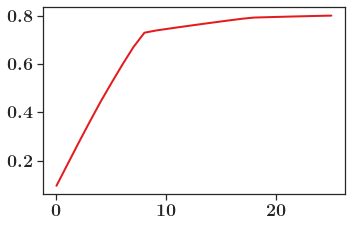

In [12]:
plt.plot(cumulative_variance)

In [13]:
np.argwhere(cumulative_variance > 0.8)[0]
# cumulative_variance[16]

array([25])

In [25]:
param_dict = {
    "hidden_nodes":[256,25],
    "input_shape":(1024,),
}
max_epochs = 20
batch_size = 32
verbose = 0

model = create_vanilla_ae(param_dict)

model.compile(loss='binary_crossentropy', 
              optimizer='adam')

loss = model.fit(
            X_train,X_train,
            validation_data=(X_test,X_test),
            epochs=max_epochs,
            batch_size=batch_size,
            verbose=verbose)

X_reconstructed_vanilla_ae = model.predict(X)

In [26]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 25)                268825    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1024)              270474    
Total params: 539,299
Trainable params: 539,299
Non-trainable params: 0
_________________________________________________________________


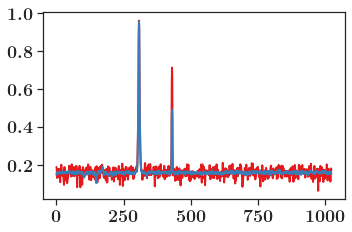

In [15]:
plt.plot(X[0,:])
plt.plot(X_reconstructed_vanilla_ae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

In [34]:
param_dict = {
    "hidden_nodes":[512],
    "input_shape":[1024,],
    "codings_size":32,
}
max_epochs = 40
batch_size = 64
verbose = 1

model,_,_ = create_vanilla_vae(param_dict)

model.compile(loss='binary_crossentropy', 
              optimizer='adam')

loss = model.fit(
            X_train,X_train,
            validation_data=(X_test,X_test),
            epochs=max_epochs,
            batch_size=batch_size,
            verbose=verbose)

X_reconstructed_vanilla_vae = model.predict(X)

Train on 1120 samples, validate on 280 samples
Epoch 1/40
1120/1120 [==============================] - 1s 503us/sample - loss: 0.5342 - val_loss: 0.4647
Epoch 2/40
1120/1120 [==============================] - 0s 73us/sample - loss: 0.4643 - val_loss: 0.4608
Epoch 3/40
1120/1120 [==============================] - 0s 76us/sample - loss: 0.4617 - val_loss: 0.4613
Epoch 4/40
1120/1120 [==============================] - 0s 71us/sample - loss: 0.4603 - val_loss: 0.4578
Epoch 5/40
1120/1120 [==============================] - 0s 73us/sample - loss: 0.4579 - val_loss: 0.4578
Epoch 6/40
1120/1120 [==============================] - 0s 73us/sample - loss: 0.4563 - val_loss: 0.4556
Epoch 7/40
1120/1120 [==============================] - 0s 70us/sample - loss: 0.4546 - val_loss: 0.4544
Epoch 8/40
1120/1120 [==============================] - 0s 73us/sample - loss: 0.4539 - val_loss: 0.4548
Epoch 9/40
1120/1120 [==============================] - 0s 72us/sample - loss: 0.4543 - val_loss: 0.4528
Epoch 1

In [37]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
model_15 (Model)                [(None, 32), (None,  557632      input_11[0][0]                   
__________________________________________________________________________________________________
model_16 (Model)                (None, 1024)         542208      model_15[1][2]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 512)          524800      input_11[0][0]                   
___________________________________________________________________________________________

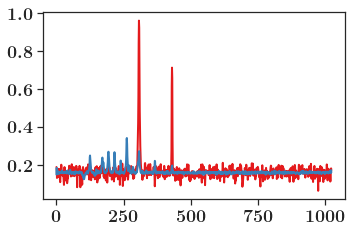

In [36]:
plt.plot(X[0,:])
plt.plot(X_reconstructed_vanilla_vae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 25)                268825    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1024)              270474    
Total params: 539,299
Trainable params: 539,299
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.input

<tf.Tensor 'sequential_input:0' shape=(None, 1024) dtype=float32>

In [43]:
filters=[20,20]
kernels = [9,3]
strides=[1,1,1]
dilation_rates=[1,1,1]
input_shape = [1024,1]
dense_nodes = [64]
codings_size = 8

param_dict = {
    "filters":filters,
    "kernels":kernels,
    "strides":strides,
    "dilation_rates":dilation_rates,
    "input_shape":input_shape,
    "dense_nodes":dense_nodes,
    "codings_size":codings_size
}

model,vae_encoder,vae_decoder = create_conv_vae(param_dict)

In [44]:
model.compile(loss='binary_crossentropy',optimizer='adam')
history = model.fit(X_train[...,np.newaxis],X_train[...,np.newaxis],
                    epochs=20,batch_size=64,
                    validation_data=[X_test[...,np.newaxis],X_test[...,np.newaxis]])

Train on 1120 samples, validate on 280 samples
Epoch 1/20
1120/1120 [==============================] - 3s 3ms/sample - loss: 0.6433 - val_loss: 0.4463
Epoch 2/20
1120/1120 [==============================] - 0s 292us/sample - loss: 0.4784 - val_loss: 0.4464
Epoch 3/20
1120/1120 [==============================] - 0s 300us/sample - loss: 0.4636 - val_loss: 0.4460
Epoch 4/20
1120/1120 [==============================] - 0s 304us/sample - loss: 0.4577 - val_loss: 0.4459
Epoch 5/20
1120/1120 [==============================] - 0s 307us/sample - loss: 0.4549 - val_loss: 0.4459
Epoch 6/20
1120/1120 [==============================] - 0s 310us/sample - loss: 0.4524 - val_loss: 0.4459
Epoch 7/20
1120/1120 [==============================] - 0s 284us/sample - loss: 0.4507 - val_loss: 0.4460
Epoch 8/20
1120/1120 [==============================] - 0s 303us/sample - loss: 0.4496 - val_loss: 0.4461
Epoch 9/20
1120/1120 [==============================] - 0s 295us/sample - loss: 0.4487 - val_loss: 0.4462
E

In [45]:
X_reconstructed_cnn_vae = model.predict(X[...,np.newaxis])
print(X_reconstructed_cnn_vae[0,:].shape)
print(X[0,:].shape)


(1024, 1)
(1024,)


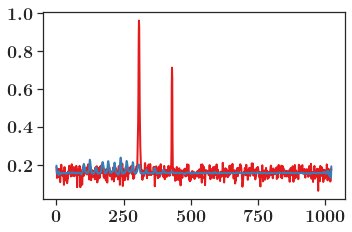

In [46]:
plt.plot(X[0,:])
plt.plot(X_reconstructed_cnn_vae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

In [38]:
filters=[20]
kernels = [3]
strides=[1,1,1]
dilation_rates=[1,1,1]
input_shape = [1024,1]
dense_nodes = [32]
codings_size = 16

param_dict = {
    "filters":filters,
    "kernels":kernels,
    "strides":strides,
    "dilation_rates":dilation_rates,
    "input_shape":input_shape,
    "dense_nodes":dense_nodes,
    "codings_size":codings_size
}

model = create_conv_ae(param_dict)

In [39]:
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train[...,np.newaxis],X_train[...,np.newaxis],
                    epochs=40,batch_size=64,
                    validation_data=[X_test[...,np.newaxis],X_test[...,np.newaxis]])

Train on 1120 samples, validate on 280 samples
Epoch 1/40
1120/1120 [==============================] - 3s 2ms/sample - loss: 0.0800 - val_loss: 0.0716
Epoch 2/40
1120/1120 [==============================] - 0s 168us/sample - loss: 0.0368 - val_loss: 0.0201
Epoch 3/40
1120/1120 [==============================] - 0s 172us/sample - loss: 0.0130 - val_loss: 0.0037
Epoch 4/40
1120/1120 [==============================] - 0s 171us/sample - loss: 0.0097 - val_loss: 0.0031
Epoch 5/40
1120/1120 [==============================] - 0s 171us/sample - loss: 0.0090 - val_loss: 0.0043
Epoch 6/40
1120/1120 [==============================] - 0s 172us/sample - loss: 0.0086 - val_loss: 0.0044
Epoch 7/40
1120/1120 [==============================] - 0s 162us/sample - loss: 0.0081 - val_loss: 0.0036
Epoch 8/40
1120/1120 [==============================] - 0s 172us/sample - loss: 0.0073 - val_loss: 0.0030
Epoch 9/40
1120/1120 [==============================] - 0s 170us/sample - loss: 0.0062 - val_loss: 0.0026
E

In [40]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 512, 20)           160       
_________________________________________________________________
sequential_7 (Sequential)    (None, 1024, 1)           1281      
Total params: 1,441
Trainable params: 1,401
Non-trainable params: 40
_________________________________________________________________


In [41]:
X_reconstructed_cnn_ae = model.predict(X[...,np.newaxis])
print(X_reconstructed_cnn_ae[0,:].shape)
print(X[0,:].shape)

(1024, 1)
(1024,)


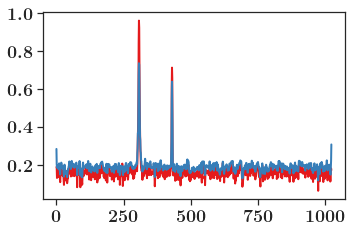

In [42]:
plt.plot(X[0,:])
plt.plot(X_reconstructed_cnn_ae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

In [60]:
from tensorflow.keras import backend as K
from tensorflow import keras


class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[1024])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(1024, activation="sigmoid")(x)
outputs = keras.layers.Reshape([1024])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 1024.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=8,
                             validation_data=[X_test, X_test])

Train on 1120 samples, validate on 280 samples
Epoch 1/25
1120/1120 [==============================] - 1s 1ms/sample - loss: 0.4716 - rounded_accuracy: 0.9792 - val_loss: 0.4510 - val_rounded_accuracy: 0.9950
Epoch 2/25
1120/1120 [==============================] - 1s 527us/sample - loss: 0.4536 - rounded_accuracy: 0.9940 - val_loss: 0.4487 - val_rounded_accuracy: 0.9950
Epoch 3/25
1120/1120 [==============================] - 1s 548us/sample - loss: 0.4510 - rounded_accuracy: 0.9940 - val_loss: 0.4506 - val_rounded_accuracy: 0.9950
Epoch 4/25
1120/1120 [==============================] - 1s 523us/sample - loss: 0.4491 - rounded_accuracy: 0.9949 - val_loss: 0.4467 - val_rounded_accuracy: 0.9950
Epoch 5/25
1120/1120 [==============================] - 1s 564us/sample - loss: 0.4472 - rounded_accuracy: 0.9949 - val_loss: 0.4460 - val_rounded_accuracy: 0.9950
Epoch 6/25
1120/1120 [==============================] - 1s 534us/sample - loss: 0.4460 - rounded_accuracy: 0.9949 - val_loss: 0.4454 - 

In [61]:
X_predicted = variational_ae.predict(X)

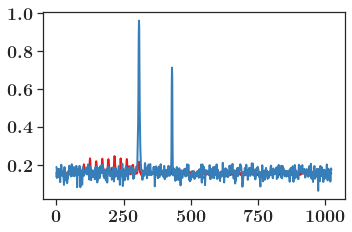

In [62]:
plt.plot(X_predicted[0,:])
plt.plot(X[0,:])